In [77]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from skimage.feature import hog
from skimage.filters import farid, gaussian

In [2]:
# Read the parquet file, this takes a while. Leave it here
dft = pl.read_parquet("Train.parquet", use_pyarrow=True, memory_map=True)

In [104]:
def restore_image_from_list(width: int, height: int, image: list) -> np.array:
    return np.array(image).reshape((height, width, 3))


def image_for_display(image: np.array) -> np.array:
    """
    Convert image to 0-255 range
    """
    return np.clip((image * 256), 0, 255).astype(np.uint8)


def blur_image(image: np.array) -> np.array:
    """
    Blur the image to remove noise
    """
    return gaussian(image, sigma=2, channel_axis=-1)


def edge_detection(image: np.array) -> np.array:
    l_channel, a_channel, b_channel = cv2.split(cv2.cvtColor(image, cv2.COLOR_RGB2LAB))
    return farid(l_channel, axis=-1)


def create_hog_features(image: np.array) -> np.array:
    """
    The best parameters for the HOG features are:
            block_norm="L2-Hys",
            pixels_per_cell=(6, 6),
            cells_per_block=(2, 2),
    There appears to be no difference betwen using the RGB or LAB color space
    Therefore we will use the RGB color space
    The hog image doesn't need to be 0-255 it will work with a normalized image
    as input
    """
    # image = (image * 255).astype(np.uint8)
    # l_channel, a_channel, b_channel = cv2.split(cv2.cvtColor(image, cv2.COLOR_RGB2LAB))
    # features_lab, hog_image_lab = hog(
    #    l_channel,
    #    orientations=9,
    #    block_norm="L2-Hys",
    #    pixels_per_cell=(6, 6),
    #    cells_per_block=(2, 2),
    #    visualize=True,
    #    #channel_axis=-1
    # )
    features_rgb, hog_image_rgb = hog(
        image,
        orientations=9,
        block_norm="L2-Hys",
        pixels_per_cell=(6, 6),
        cells_per_block=(2, 2),
        visualize=True,
        channel_axis=-1,
    )
    return features_rgb, hog_image_rgb


def create_hog_features_single(image: np.array) -> np.array:
    """
    The best parameters for the HOG features are:
            block_norm="L2-Hys",
            pixels_per_cell=(6, 6),
            cells_per_block=(2, 2),
    There appears to be no difference betwen using the RGB or LAB color space
    Therefore we will use the RGB color space
    The hog image doesn't need to be 0-255 it will work with a normalized image
    as input
    """
    # image = (image * 255).astype(np.uint8)
    # l_channel, a_channel, b_channel = cv2.split(cv2.cvtColor(image, cv2.COLOR_RGB2LAB))
    # features_lab, hog_image_lab = hog(
    #    l_channel,
    #    orientations=9,
    #    block_norm="L2-Hys",
    #    pixels_per_cell=(6, 6),
    #    cells_per_block=(2, 2),
    #    visualize=True,
    #    #channel_axis=-1
    # )
    features_rgb, hog_image_rgb = hog(
        image,
        orientations=9,
        block_norm="L2-Hys",
        pixels_per_cell=(6, 6),
        cells_per_block=(2, 2),
        visualize=True,
    )
    return features_rgb, hog_image_rgb

Text(0.5, 1.0, 'HOG from edge detection')

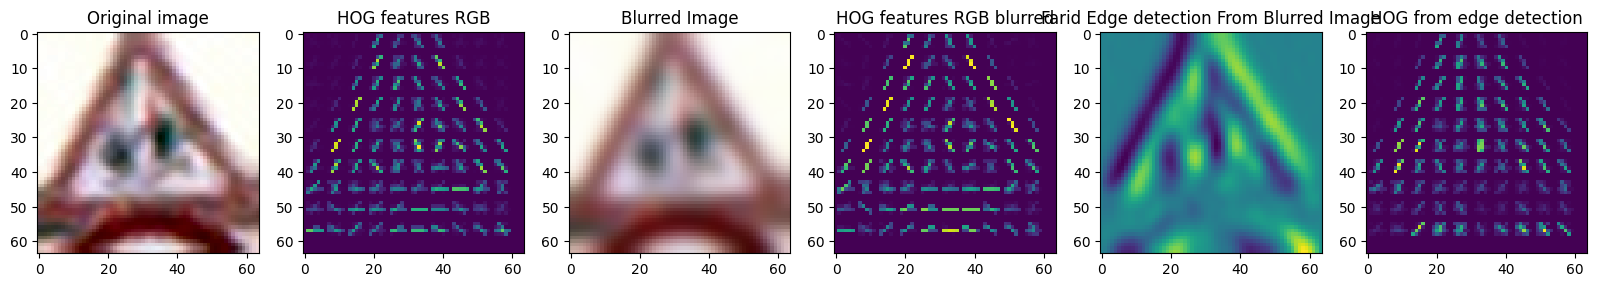

In [148]:
##################################################
##
## HOG seems to work best with the raw image not blurred or not edge detected
##
samples = dft.sample(100, with_replacement=False)

features_rgb, hog_image_rgb = create_hog_features(
    restore_image_from_list(
        samples["Scaled_Width"][0],
        samples["Scaled_Height"][0],
        samples["Stretched_Histogram_Image"][0],
    )
)

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 6, 1)
original_image = image_for_display(
    restore_image_from_list(
        samples["Scaled_Width"][0],
        samples["Scaled_Height"][0],
        samples["Stretched_Histogram_Image"][0],
    )
)
ax.imshow(original_image)
ax.set_title("Original image")
ax = fig.add_subplot(1, 6, 2)
ax.imshow(hog_image_rgb)
ax.set_title("HOG features RGB")
ax = fig.add_subplot(1, 6, 3)
blurred_image = blur_image(
    image_for_display(
        restore_image_from_list(
            samples["Scaled_Width"][0],
            samples["Scaled_Height"][0],
            samples["Stretched_Histogram_Image"][0],
        )
    )
)
ax.imshow(blurred_image)
ax.set_title("Blurred Image")
ax = fig.add_subplot(1, 6, 4)
features_blurred_rgb, hog_blurred_image_rgb = create_hog_features(blurred_image)
ax.imshow(hog_blurred_image_rgb)
ax.set_title("HOG features RGB blurred")
ax = fig.add_subplot(1, 6, 5)
ax.imshow(edge_detection((blurred_image * 255).astype(np.uint8)))
ax.set_title("Farid Edge detection From Blurred Image")

hog_features, hog_image = create_hog_features_single(
    edge_detection((original_image * 255).astype(np.uint8))
)
ax = fig.add_subplot(1, 6, 6)
ax.imshow(hog_image)
ax.set_title("HOG from edge detection")